In [135]:
'''
Load libs
'''
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from skimage import io, transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [69]:
'''
Define data folders 
'''
imgs_dir = './ISIC/images'
mask_dir = './ISIC/masks'
info_filename = './ISIC/imagedata.csv'

In [70]:
'''
Load metadata
'''
info = pd.read_csv(info_filename)
info.head()

,isic_id,age_approx,anatom_site_general,benign_malignant,diagnosis,diagnosis_confirm_type,melanocytic,sex
0,ISIC_0000000,55.0,anterior torso,benign,nevus,NaN,True,female
1,ISIC_0000001,30.0,anterior torso,benign,nevus,NaN,True,female
2,ISIC_0000002,60.0,upper extremity,malignant,melanoma,histopathology,True,female
3,ISIC_0000003,30.0,upper extremity,benign,nevus,NaN,True,male
4,ISIC_0000004,80.0,posterior torso,malignant,melanoma,histopathology,True,male


In [111]:
def show_imgmask(img, mask, ax=None):
    if ax:
        ax.imshow(img)
        ax.imshow(mask, alpha=0.3)
    else:
        plt.imshow(img)
        plt.imshow(mask, alpha=0.3)
        plt.axis('off')
        plt.show()

./ISIC/images/ISIC_0000000.png
./ISIC/masks/ISIC_0000000_mask.png


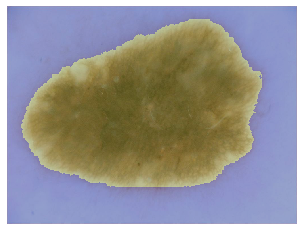

In [88]:
'''
Load one image and one mask
'''
index = 0

# Load image
img_filename = imgs_dir+'/'+info['isic_id'][index]+'.png'
print(img_filename)
img = io.imread(img_filename)

# Load mask
mask_filename = mask_dir+'/'+info['isic_id'][index]+'_mask.png'
print(mask_filename)
mask = io.imread(mask_filename)

show_imgmask(img, mask)

In [89]:
'''
Create a class for our dataset
'''

class ISICDataset(Dataset):
    '''ISIC images masks dataset'''
    
    def __init__(self, imgs_dir, mask_dir, info_filename, transform=None):
        '''
        Args:
            imgs_dir (string): Directory with all images
            mask_dir (string): Directory with all masks
            info_filename (string): Path to the csv file with information about images
            transform (callable, optional): Optional transform to be applied on a sample.
        '''
        self.imgs_dir = imgs_dir
        self.mask_dir = mask_dir
        self.info = pd.read_csv(meta_file)
        self.transform = transform
    
    def __len__(self):
        return info.shape[0]
    
    def __getitem__(self, index):
        if t.is_tensor(index):
            index = index.tolist()
            
        img_filename = self.imgs_dir+'/'+self.info['isic_id'][index]+'.png'
        mask_filename = self.mask_dir+'/'+self.info['isic_id'][index]+'_mask.png'
        
        image = io.imread(img_filename)
        mask = io.imread(mask_filename)
        
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

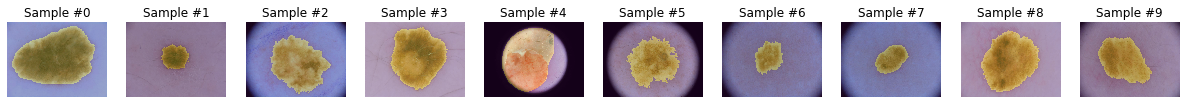

In [100]:
'''
Example of work ISICDataset class
'''

isic_dataset = ISICDataset(imgs_dir, mask_dir, info_filename)

n_images = 10

fig, ax = plt.subplots(1,n_images, figsize=(21,12))

for i in range(n_images):
    sample = isic_dataset[i]
    
#     print(i, sample['image'].shape, sample['mask'].shape)

    ax[i].set_title('Sample #{}'.format(i))
    ax[i].axis('off')
    show_imgmask(sample['image'], sample['mask'], ax[i])
plt.show()

In [136]:
'''
Creating transforms
'''
class Rescale(object):
    '''Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    '''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        h, w = sample['image'].shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))
        
        return {'image': img, 'mask': msk}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
            
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
#         mask = mask.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask).unsqueeze(0)}

In [131]:
img, mask = sample['image'], sample['mask']

print(img.transpose((2, 0, 1)).shape)
print(img.shape)

print(t.from_numpy(mask).unsqueeze(0).shape)
# print(mask.transpose((2, 0, 1)).shape)




(3, 1129, 1504)
(1129, 1504, 3)
torch.Size([1, 1129, 1504])


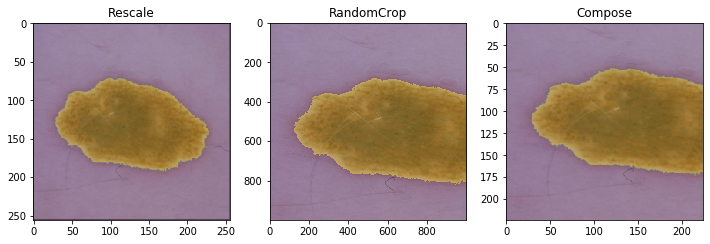

In [137]:
scale = Rescale((256, 256))
crop = RandomCrop(1000)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
# Apply each of the above transforms on sample.
sample = isic_dataset[65]

fig, ax = plt.subplots(1,3, figsize=(12,6))

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax[i].set_title(type(tsfrm).__name__)
    show_imgmask(transformed_sample['image'], transformed_sample['mask'], ax[i])

plt.show()

In [138]:
transformed_dataset = ISICDataset(imgs_dir, 
                                  mask_dir, 
                                  info_filename, 
                                  transform=transforms.Compose([
                                      Rescale((256,256)),
                                      ToTensor()
                                  ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['mask'].size())

    if i == 3:
        break

0 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
1 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
2 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
3 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
